# Coolstore Evaluation

In this notebook, we evaluate the value proposition of Kai. Kai uses additional data from Konveyor Hub (solved examples), static code analysis as well as the rules themselves to augment an LLM prompt to get better quality responses. This is in contrast to using an LLM directly with little or no specific information in the prompts. 

We will work with Kai to provide fixes for issues identified in [Coolstore](https://github.com/konveyor-ecosystem/coolstore) app for different kinds of issues. The fixes for these issues involve varying levels of complexity. For each issue, we try to evaluate the responses under two conditions - with and without supplemental information from the analysis. In the supplemental analysis information, we will permute between text description about issues, previous solved examples, static code analysis information, etc.

Finally, we will compare how well Kai does against zero-shot prompts without much analysis information.

For evaluating the responses, we will use different approaches based on complexity of a fix in question. For easy fixes, we will use [evaluation.py](../../kai/evaluation.py) which uses edit distance. For more complex fixes, we will be using another LLM to evaluate based on a well defined criteria.

For comparing with expected output, we will use already modernized version of coolstore app for Quarkus which can be found in `quarkus` branch of the repo [here](https://github.com/konveyor-ecosystem/coolstore/tree/quarkus).

## Pre-requisites

To run snippets in this notebook, you first need to set up Kai's virtualenv in the [base dir](../../).

Activate the virtualenv and install the Jupyter kernel for it:

```sh
python -m ipykernel install --user --name=<your-venv-dir>
```

We also need an additional package for plotting charts which we will install in our environment:

```sh
pip install matplotlib
```

Once installed, you should be able to use your Kai venv for this notebook. In VsCode, this can be done in the upper right corner. 

Then, create a `.env` file in the [base dir](../../) that contains export commands to source your LLM access keys:

```sh
export GENAI_KEY=<your-ibm-key>
export OPENAI_API_KEY=<your-openai-key>
```

Note that both IBM and OpenAI keys are needed. 

Once `.env` file is ready, run the following cell to source the keys in notebook environment:

In [2]:
# make sure you set GENAI_KEY / OPENAI_KEY

%load_ext dotenv
%dotenv

Now, we will parse the analysis output to load the data into memory we need for the experiments. Continue running the cells in sequence one-by-one to advance.

In [3]:
# first we load incidents into memory and group by files for better access

import sys
sys.path.append('../../../kai')
from kai.models.report import Report

output_file = './analysis_output.yaml'
report = Report.load_report_from_file(output_file)
files = report.get_impacted_files()

# we filter out filepaths for dependencies
to_delete = []
for k in files: 
    if k.startswith('root/.m2'): to_delete.append(k)
for d in to_delete: del(files[d])

# printing file names and incidents in each file
for f in files: print(len(files[f]), f)

1 src/main/webapp/WEB-INF/web.xml
12 pom.xml
10 src/main/java/com/redhat/coolstore/model/Order.java
6 src/main/java/com/redhat/coolstore/model/OrderItem.java
5 src/main/webapp/WEB-INF/beans.xml
8 src/main/resources/META-INF/persistence.xml
6 src/main/java/com/redhat/coolstore/model/InventoryEntity.java
1 src/main/java/com/redhat/coolstore/model/ShoppingCart.java
6 src/main/java/com/redhat/coolstore/persistence/Resources.java
9 src/main/java/com/redhat/coolstore/rest/CartEndpoint.java
8 src/main/java/com/redhat/coolstore/rest/OrderEndpoint.java
3 src/main/java/com/redhat/coolstore/rest/ProductEndpoint.java
4 src/main/java/com/redhat/coolstore/rest/RestApplication.java
8 src/main/java/com/redhat/coolstore/service/CatalogService.java
2 src/main/java/com/redhat/coolstore/service/InventoryNotificationMDB.java
8 src/main/java/com/redhat/coolstore/service/OrderService.java
15 src/main/java/com/redhat/coolstore/service/OrderServiceMDB.java
3 src/main/java/com/redhat/coolstore/service/ProductSe

From the files displayed above, we will be focusing on following files in our experiments:

* src/main/java/com/redhat/coolstore/model/ShoppingCart.java
* src/main/java/com/redhat/coolstore/model/InventoryEntity.java
* src/main/java/com/redhat/coolstore/service/CatalogService.java
* src/main/java/com/redhat/coolstore/service/ShippingService.java
* src/main/java/com/redhat/coolstore/service/ShoppingCartOrderProcessor.java

These files appear in our demo example found [here](https://github.com/konveyor/kai/blob/main/docs/scenarios/demo.md)

Next up, we will clone the example app. The following cell will create a `data` directory to contain all the data we will generate when running experiments.

In [4]:
# now we will get our test data
import os
import errno
from git import Repo
import importlib

def ensure_dirs(dir):
    try:
        os.makedirs(dir)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

def clone_coolstore(branch: str, path: str):
    try:
        Repo.clone_from("https://github.com/konveyor-ecosystem/coolstore", 
            depth=1, single_branch=True, branch=branch, to_path=path)
    except Exception as e:
        if "already exists" not in str(e):
            print("fatal error cloning repo")
            sys.exit(1)

ensure_dirs("./data/apps/coolstore/")
clone_coolstore("quarkus", "./data/apps/coolstore/quarkus")
clone_coolstore("main", "./data/apps/coolstore/javaee")

Next, we will compile our analysis data as well as source code of affected files into a data structure for accessing later.

In [5]:
# now we will create data required for evaluation
from datetime import datetime
from kai.evaluation import BenchmarkExample, evaluate, BenchmarkResult
from kai.service.incident_store import Application

examples = {}
for f in files:
    original_content = ""
    expected_content = ""
    with open(f"./data/apps/coolstore/javaee/{f}", "r") as fl: original_content = fl.read()
    if os.path.exists(f"./data/apps/coolstore/quarkus/{f}"): 
        with open(f"./data/apps/coolstore/quarkus/{f}", "r") as fl: expected_content = fl.read()
    examples[f] = BenchmarkExample(
        application=Application(
            application_name="coolstore",
            current_branch="main",
            repo_uri_local="./data/apps/coolstore/javaee",
            generated_at=datetime.strptime("24/05/09 19:32:00", "%y/%m/%d %H:%M:%S"),
            repo_uri_origin="https://github.com/konveyor-ecosystem/coolstore",
            current_commit="aa"
        ),
        expected_file=expected_content,
        incidents=files[f],
        original_file=original_content,
        name=os.path.basename(f),
        report=report,
    )

We will create some config files (in-memory) which we need to run Kai.

In [6]:
from jinja2 import Template

CONFIG_BASE_PATH = "./data/configs/"
OUTPUT_BASE_PATH = "./data/outputs/"

ensure_dirs(CONFIG_BASE_PATH)
ensure_dirs(OUTPUT_BASE_PATH)

templ = Template("""
trace_enabled = true
demo_mode = false
log_dir = "$pwd/logs"
file_log_level = "debug"
log_level = "info"

[models]
provider = "{{ model_provider }}"
template = "{{ prompt_template }}"

[models.args]
{% if model_provider == "ChatOpenAI" %}
model = "{{ model_id }}"
{% else %}
model_id = "{{ model_id }}"
{% endif %}
{% if max_tokens != "" %}
parameters.max_new_tokens = "{{ max_tokens }}"
{% endif %}

[incident_store]
solution_detectors = "naive"
solution_producers = "text_only"

[incident_store.args]
provider = "postgresql"
host = "127.0.0.1"
database = "kai"
user = "kai"
password = "dog8code"
""")

# some shorthands we can use in our experiments for different models
META_LLAMA_13b = 'meta-llama-13b'
META_LLAMA_70b = 'meta-llama-70b'
MIXTRAL = 'mixtral'
IBM_GRANITE = 'ibm-granite'
GPT_4 = "gpt-4"
GPT_3 = "gpt-3"

all_models = [
    META_LLAMA_13b,
    META_LLAMA_70b,
    IBM_GRANITE,
    MIXTRAL,
    GPT_3,
    GPT_4
]

# model_provider: { model_id: {parameter: val}}
models = {
    "ChatIBMGenAI": {
        "meta-llama/llama-3-70b-instruct": {"max_tokens": "2048", "key": META_LLAMA_70b},
        "meta-llama/llama-2-13b-chat": {"max_tokens": "1536", "key": META_LLAMA_13b},
        "mistralai/mixtral-8x7b-instruct-v01": {"key": MIXTRAL},
        "ibm/granite-13b-chat-v2": {"key": IBM_GRANITE},
    },
    "ChatOpenAI": {
        "gpt-3.5-turbo": {"key": GPT_4},
        "gpt-4": {"key": GPT_3},
    },
}

configs = {}

# create configs for all models with different parameters 
# we will use these as needed in our experiments
for model_provider, model_ids in models.items():
    for model_id, parameters in model_ids.items():
        configs[parameters.get("key", "")] = Template(templ.render(
            model_provider = model_provider,
            model_id = model_id,
            max_tokens = parameters.get("max_tokens", ""),
            prompt_template = "{{ prompt_template }}"
        ))

The following cell contains some common code we will be using for experiments. There is no output for the cell, just run it before moving forward.

In [7]:
# this is common code we will use to evaluate response of LLM for one example
import json
import signal
import requests
import threading
import subprocess
from time import sleep
from kai.models.kai_config import KaiConfig
from kai.routes.get_incident_solutions_for_file import (
    PostGetIncidentSolutionsForFileParams,
)

# helper function to send requests to Kai service
def generate_fix(log: any, params: PostGetIncidentSolutionsForFileParams) -> dict:
    retries_left = 6
    for i in range(retries_left):
        try:
            headers = {"Content-type": "application/json", "Accept": "text/plain"}
            response = requests.post(
                "http://0.0.0.0:8080/get_incident_solutions_for_file",
                data=params.model_dump_json(),
                headers=headers,
                timeout=3600,
            )
            if response.status_code == 200:
                result = response.json()
                if isinstance(result, str):
                    return json.loads(result)
                elif isinstance(result, dict):
                    return result
                else:
                    return {}
            else:
                log.write(f"[{params.file_name}] Received status code {response.status_code}")
        except requests.exceptions.RequestException as e:
            log.write(f"[{params.file_name}] Received exception from Kai server: {e}")
        log.write(f"[{params.file_name}] Failed to get a '200' response from the server.  Retrying {retries_left-i} more times")
    raise(Exception(f"[{params.file_name}] Failed to get a '200' response from the server.  Parameters = {params}"))


# write a Kai config to a known location 
def ensure_config(model_key: str, experiment_key: str, prompt_template: str) -> tuple[str, str]:
    ensure_dirs(f"{CONFIG_BASE_PATH}{experiment_key}")
    config_path = f"{CONFIG_BASE_PATH}{experiment_key}/{model_key}.toml"
    config = configs[model_key].render(prompt_template=prompt_template)
    with open(config_path, "w+") as f: f.write(config)
    config_parsed = KaiConfig.model_validate_filepath(config_path)
    return config_path, config_parsed

# run Kai service, this is used when we use Kai service instead of evaluate.py for generating fixes
def ensure_kai_service(output_path: str) -> tuple[list, list]:
    processes = []
    def run_command(cmd: str, stdout: any): 
        p = subprocess.Popen(cmd, shell=True, cwd="../../", 
            env=os.environ.copy(), stdout=stdout, stderr=stdout)
        processes.append(p)
        p.wait()
    ensure_dirs(f"{output_path}")
    postgres_log = open(f"{output_path}/postgres.log", "w+")
    db_thread  = threading.Thread(target=run_command, args=("DROP_TABLES=true POSTGRES_RUN_ARGS=--rm make run-postgres", postgres_log, ))
    kai_log = open(f"{output_path}/kai.log", "w+")
    kai_thread = threading.Thread(target=run_command, args=("make run-server", kai_log, ))
    db_thread.start()
    data_load_log = open(f"{output_path}/data_load.log", "w+")
    subprocess.run(["make", "load-data"], cwd="../../", stdout=data_load_log, stderr=data_load_log)
    kai_thread.start()
    return processes, [kai_log, postgres_log, data_load_log]

# helper function to kill processes gracefully, needed to clean up Kai service and db
def kill(processes: list):
    for p in processes:
        p.send_signal(signal.SIGINT)
        p.send_signal(signal.SIGTERM)

# this function runs "evaluate" function from evaluation.py and compares LLM responses with expected output to get edit distance
def run_evaluate_for_example(model_key: str, experiment_key: str, prompt_template: str, example: BenchmarkExample):
    config_path, config_parsed = ensure_config(model_key, experiment_key, prompt_template)
    full_response = evaluate(configs={config_path: config_parsed}, examples={example.name: example})
    response = full_response[(example.name, config_path)]
    output_path = f"{OUTPUT_BASE_PATH}/using_evaluation/{experiment_key}/{model_key}"
    ensure_dirs(output_path)
    with open(f"{output_path}/llm_response", "w+") as f: f.write(response.llm_result)
    with open(f"{output_path}/edit_distance", "w+") as f: f.write(f"{response.similarity}")
    with open(f"{output_path}/updated_file", "w+") as f: f.write(f"{response.updated_file}")

# this function sends example in a query to Kai service to get LLM response
def run_kai_generate_fix(model_key: str, experiment_key: str, prompt_template: str, example: BenchmarkExample):
    output_path = f"{OUTPUT_BASE_PATH}/using_kai/{experiment_key}/{model_key}"
    ensure_dirs(output_path)
    runner_log = open(f"{output_path}/runner.log", "w+")
    config_path, config_parsed = ensure_config(model_key, experiment_key, os.path.basename(prompt_template))
    subprocess.run(['cp', f'../../kai/config.toml', f'../../kai/config.toml.temp'])
    subprocess.run(['cp', f'{config_path}', f'../../kai/config.toml'])
    subprocess.run(['cp', f'{prompt_template}', f'../../kai/data/templates/'])
    processes, logs = ensure_kai_service(output_path=output_path)
    # sleep is needed to let Kai server come up
    sleep(10)
    try:
        params = PostGetIncidentSolutionsForFileParams(
            application_name=example.application.application_name,
            file_contents=example.original_file,
            file_name=example.name,
            include_llm_results=False,
            incidents=example.incidents,
        )
        response = generate_fix(runner_log, params)
        if not response: 
            raise(f"failed to parse response")
        with open(f"{output_path}/llm_reasoning", "w+") as f: f.write(response.get('total_reasoning', [''])[0])
        with open(f"{output_path}/prompt", "w+") as f: f.write(response.get('used_prompts', [''])[0])
        with open(f"{output_path}/updated_file", "w+") as f: f.write(response.get('updated_file', ['']))
    except Exception as e:
        runner_log.write(f"failed to generate fix {e}")
    finally:
        # clean up
        subprocess.run(['rm', f'../../kai/data/templates/{os.path.basename(prompt_template)}'])
        subprocess.run(['mv', f'../../kai/config.toml.temp', f'../../kai/config.toml'])
        kill(processes)
        # sleep is needed to gracefully shutdown
        sleep(10)
        runner_log.close()
        for log in logs: log.close()
    pass

## Zero Shot with No Analysis Information

In this section, we run our first experiment. The prompt we use will have NO analysis information in it. We will ask LLM to simply generate a fixed file without telling it any more information. This is our baseline. We will run this with different models. 

### Easy example

We will run Kai for a very simple fix first. This file only contains a fix that requires changing an import from `javax` to `jakarta`.

We will run the following cell to run the easy example with different models. The outputs of this experiment will be generated in `./data/outputs/using_kai/zero_shot_easy/` directory for each model.

_Note we have seen sometimes it takes more than one try to get output from a model, especially with mixtral_

In [10]:
# this file only contains fixes that require changing imports...an easy example
example_zero_shot_easy = examples['src/main/java/com/redhat/coolstore/model/ShoppingCart.java']

# run kai-fix for all models
for model in all_models:
    print(f"generating fix using model {model}")
    run_kai_generate_fix(model, "zero_shot_easy", "./templates/zero_shot/example1.jinja", example_zero_shot_easy)
    print(f"generated fix using model {model}, output present in {OUTPUT_BASE_PATH}/using_kai/zero_shot_easy/{model}")

generating fix using model meta-llama-13b
generated fix using model meta-llama-13b, output present in ./data/outputs//using_kai/zero_shot_easy/meta-llama-13b
generating fix using model meta-llama-70b
generated fix using model meta-llama-70b, output present in ./data/outputs//using_kai/zero_shot_easy/meta-llama-70b
generating fix using model ibm-granite
generated fix using model ibm-granite, output present in ./data/outputs//using_kai/zero_shot_easy/ibm-granite
generating fix using model mixtral
generated fix using model mixtral, output present in ./data/outputs//using_kai/zero_shot_easy/mixtral
generating fix using model gpt-3
generated fix using model gpt-3, output present in ./data/outputs//using_kai/zero_shot_easy/gpt-3
generating fix using model gpt-4
generated fix using model gpt-4, output present in ./data/outputs//using_kai/zero_shot_easy/gpt-4


#### Evaluating LLM responses

Although this fix is pretty easy to make (replace an import statement), evaluating it using edit distance has been a challenge. Because, LLMs are not predictable and they may sometimes fix more things than needed, not fix anything at all and/or introduce new issues. For instance, in this file, the only change that needs to happen is replace the `javax` import with `jakarta`. If the LLM doesn't fix this issue at all, the edit distance of the LLM response with the expected file will be quite low (where low is better) because only change in the file would be that `javax` string. However, that doesn't really help us in determining whether the issue was fixed. Also, this file contains many functions. If the LLM changes function signatures etc resulting in a bigger change, the edit distance will be higher. But that doesn't mean those function definitions are wrong. They can still be valid. In none of these scenarios, we can objectively tell whether the file is actually compatible with Quarkus. 

For these reasons, we use another smarter LLM to evaluate responses. In that, we will ask the LLM to rate the migrated file (updated file returned by Kai) based on a well defined criteria. There will be 3 main metrics in the criteria, each having a rating on a scale of 0 to 5. A higher rating in all metrics is a good sign.

The metrics are:

1. Is LLM fixing the things that need to be fixed?

This metric evaluates whether LLM is doing changes than are required. We want the issues that we originally pointed out fixed in the final output. Also, we want specific changes, not unnecessary changes.

2. Is the Java file generally syntactically correct? 

With this metric, we focus on general syntactical correctness. Additionally, we specifically evaluate whether all imports are correct, function signatures are correct, etc.

3. Is the final file suitable for Quarkus? Are there more changes needed to be done?

Here, we evaluate based on whether the final file is compatible with Quarkus. We also see if there were any new issues introduced in the file.

We don't care about all these metrics equally, so we take an weighted average with weights being 0.6, 0.3, 0.1 from top to bottom.

The assumption is that the LLM we use for evaluation is inherently knowledgeable about Quarkus and will be accurate enough to give us a good high level picture of the quality of responses. We will use `gpt-4` in this case. Find our evaluation prompt [here](./templates/evaluation.jinja). 

We understand that this is not a perfect way to evaluate. But, we can improve on evaluation itself. We are not including any examples of evaluation in our prompt right now. We can include some relevant examples pertaining to issues in the file to get better evaluation results.

With that said, we are not interested in the exact ratings in evaluation. The goal is just to get an insight into how well a LLM performs when it is given additional information from incidents. That is where the magic of Kai happens. And conclusion we are looking for is whether that magic is really useful. So we will be only looking at evaluation results in relative scale.

To run the evaluation, you will require _OPENAI_API_KEY_, make sure it's present in your '.env' file and you have run the very first code cell in this notebook after adding it. 

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from langchain.chat_models import ChatOpenAI
from langchain.schema import StrOutputParser
from jinja2 import Environment, FileSystemLoader

evaluation_criteria = {
    0: 'Issue Fixed?',
    1: 'General syntax correct?',
    2: 'Suitable for Quarkus?',
}

template_env = Environment(
    loader=FileSystemLoader(searchpath="./templates/"))

# function to evaluate updated file generated with kai using gpt-4 
def evaluate_with_gpt(key: str, example: BenchmarkExample, updated_file: str) -> str:    
    t = template_env.get_template("evaluate.jinja").render(
        incidents=example.incidents, original_file=example.original_file, 
        updated_file=updated_file)
    llm = ChatOpenAI(model_name="gpt-4")
    output = llm.invoke(t)
    return output.content

# parses evaluation output
def parse_evaluation_output(output: str) -> tuple[list[int], list[str]]:
    ratings = []
    reasoning = []
    for idx, line in enumerate(output.strip('\n').strip('```').replace("\n\n", "\n").split("\n")):
        if idx % 2 == 0:
            ratings.append(float(line))
        else:
            reasoning.append(line)
    return ratings, reasoning

def plot_evaluation_score(data: dict):
    keys = list(data.keys())
    values = np.array(list(data.values()))
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(keys, values)
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')
    ax.set_ylim(0, 5)
    ax.set_xlabel('Models')
    ax.set_ylabel('Score')
    ax.set_title('Evaluation Score by Model')
    fig.tight_layout()
    plt.show()

def plot_multibar_chart(data_list: list[tuple[dict, str]]):
    num_datasets = len(data_list)
    x = np.arange(data_list[0][0].keys())  
    width = 0.8 / num_datasets
    fig, ax = plt.subplots(figsize=(12, 6))
    for i, dataset in enumerate(data_list):
        values = list(dataset.values())
        bars = ax.bar(x - width * (num_datasets/2 - i), values, width, label=f'{data_list[i][1]}')    
        for bar in bars:
            height = bar.get_height()
            ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
    ax.set_xlabel('Models')
    ax.set_ylabel('Score')
    ax.set_title('Evaluation score by models')
    ax.set_xticks(x)
    ax.set_xticklabels(data_list[0][0].keys())
    ax.legend()

# given raw evaluation output from models, plots the chart and prints reasoning 
def plot_chart_and_print_reasoning(eval_output: dict):
    data = {}
    for model in all_models:
        data[model] = parse_evaluation_output(eval_output[model])
    plot_evaluation_score({k: np.average(v[0], weights=[0.6, 0.3, 0.1]) for k, v in data.items()})
    for model in all_models:
        print(f"{'* '}{model}")
        for idx, reasoning in enumerate(data[model][1]):
            print(f"\t{idx+1}. {reasoning}")

# given multiple eval outputs, plots a chart side-by-side for comparison
def plot_multibar_chart_from_eval_outputs(eval_outputs: list[tuple[dict, str]]):
    data_list = []
    for eval_output, label in eval_outputs:
        for model in all_models:
            model_data = parse_evaluation_output(eval_output[model])
            data_list.append(({k: np.average(v[0], weights=[0.6, 0.3, 0.1]) for k, v in model_data.items()}, label))
    # plot_multibar_chart(data_list)


In [80]:
zero_shot_easy_eval_output = {}
for model in all_models:
    # get updated file
    base_output_path = "./data/outputs/using_kai/zero_shot_easy"
    updated_content = ""
    with open(f"{base_output_path}/{model}/updated_file", "r") as f: updated_content = f.read()    
    zero_shot_easy_eval_output[model] = evaluate_with_gpt(model, example_zero_shot_easy, updated_content)

Now that we have data from our first experiment, we will plot a bar chart. And also print reasoning behind each score our evaluation produced for different models.

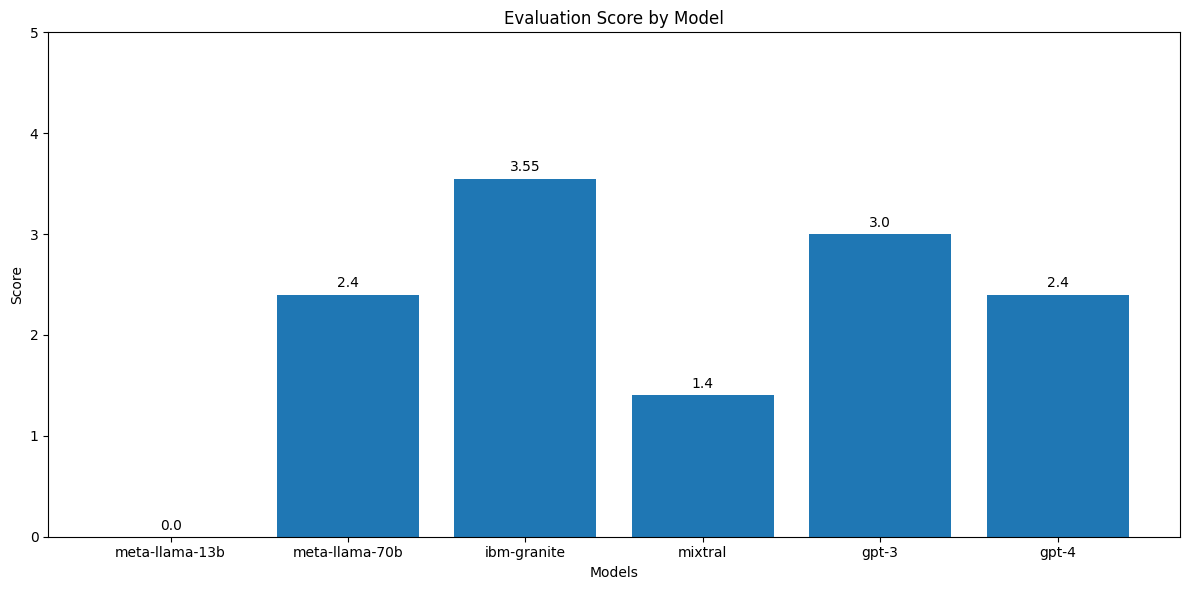

* meta-llama-13b
	1. The issue identified in the JavaEE file is not addressed in the updated file. The import statement for `javax.enterprise` is not replaced with `jakarta.enterprise`.
	2. The updated file has several syntax errors. The `Serializable` interface is not imported and used without being declared. The `@Bean` annotation is used without being imported. All the getter and setter methods are declared private, which is not a good practice as it restricts their accessibility.
	3. The updated file is not suitable for Quarkus. The `@Bean` annotation is not a standard Quarkus annotation. The `Serializable` interface used is not imported correctly. Without these corrections, the file cannot work successfully with Quarkus.
* meta-llama-70b
	1. The issue identified was not fixed in the migrated Quarkus file. The `javax.enterprise.context.Dependent` import was removed completely instead of being replaced with `jakarta.enterprise.context.Dependent`.
	2. The updated file doesn't have an

In [81]:

plot_chart_and_print_reasoning(zero_shot_easy_eval_output)

All of the files generated by different models used in above evaluation can be found under [results/zero_shot_easy](./results/zero_shot_easy/) directory. If you look at the reasoning our evaluation model produced for each output, and compare that with the actual generated file, we can see that the scores rightly (somewhat) reflect the idea of "accuracy" of a certain fix. One important point to note here is that since this file only contained one issue, the evaluation output is pretty much binary (remember, we have the highest weight on metric 1 i.e. whether the issue is fixed or not). This won't be the case for more harder cases further ahead.

Note that absolute rating numbers don't matter much. We are more interested in looking at how a model does relatively in different scenarios. Finally, we will be looking at the trend of how things improved as Kai added more and more contextual information to the prompt.

### Relatively harder example

Now we will run the same experiment with a harder example. In this file we will use, there are more than one incidents present. Some of these incidents contain changes to imports as well as require replacing some annotations.

In [61]:
# this file only contains fixes that require changing imports...an easy example
example_zero_shot_hard = examples['src/main/java/com/redhat/coolstore/service/ShippingService.java']

# run kai-fix for all models
for model in all_models:
    print(f"generating fix using model {model}")
    run_kai_generate_fix(model, "zero_shot_hard", "./templates/zero_shot/example1.jinja", example_zero_shot_hard)
    print(f"generated fix using model {model}, output present in {OUTPUT_BASE_PATH}/using_kai/zero_shot_hard/{model}")

generating fix using model meta-llama-13b
generated fix using model meta-llama-13b, output present in ./data/outputs//using_kai/zero_shot_hard/meta-llama-13b
generating fix using model meta-llama-70b
generated fix using model meta-llama-70b, output present in ./data/outputs//using_kai/zero_shot_hard/meta-llama-70b
generating fix using model ibm-granite
generated fix using model ibm-granite, output present in ./data/outputs//using_kai/zero_shot_hard/ibm-granite
generating fix using model mixtral
generated fix using model mixtral, output present in ./data/outputs//using_kai/zero_shot_hard/mixtral
generating fix using model gpt-3
generated fix using model gpt-3, output present in ./data/outputs//using_kai/zero_shot_hard/gpt-3
generating fix using model gpt-4
generated fix using model gpt-4, output present in ./data/outputs//using_kai/zero_shot_hard/gpt-4


The output for above experiment can be found under [data/outputs/using_kai/zero_shot_hard](./data/outputs/using_kai/zero_shot_hard) directory. Now we will run the evaluation.

In [66]:
zero_shot_hard_eval_output = {}
for model in all_models:
    # get updated file
    base_output_path = "./data/outputs/using_kai/zero_shot_hard"
    updated_content = ""
    with open(f"{base_output_path}/{model}/updated_file", "r") as f: updated_content = f.read()    
    zero_shot_hard_eval_output[model] = evaluate_with_gpt(model, example_zero_shot_hard, updated_content)

Now we plot the chart.

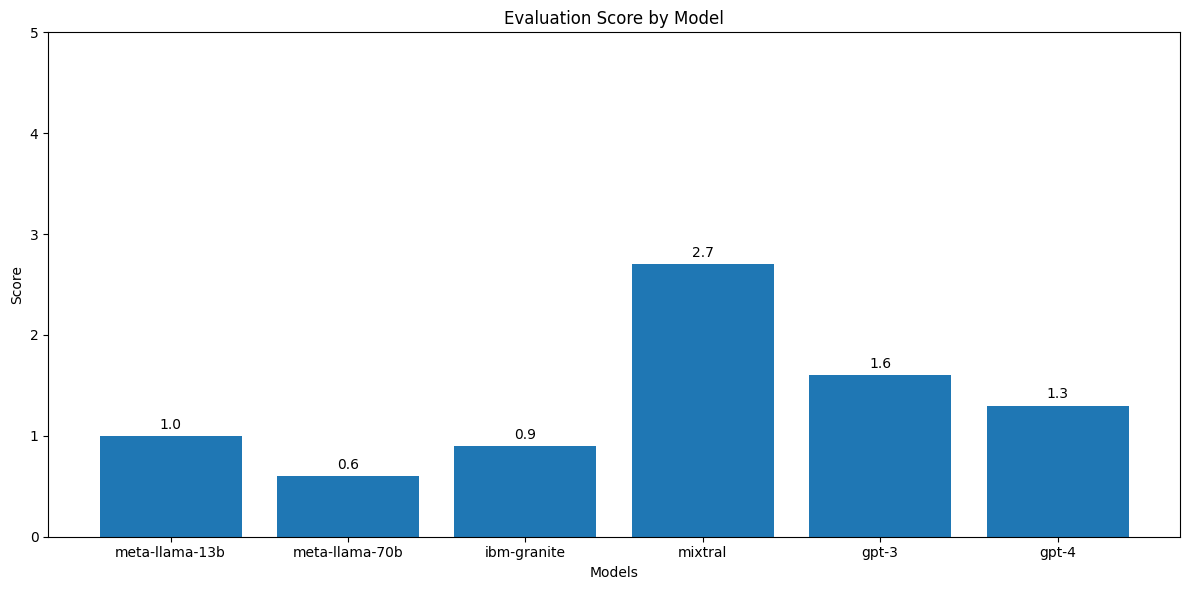

* meta-llama-13b
	1. The updated file only partially addresses the issues identified in the JavaEE file. It has attempted to replace the `@Stateless` annotation with `@Bean`, which is incorrect as it should have been replaced with a scope like `@ApplicationScoped`. It also doesn't replace the `@Remote` annotation with `@jakarta.ws.rs.Path("<endpoint>")` and doesn't annotate the methods with `@jakarta.ws.rs.GET` or `@jakarta.ws.rs.POST`.
	2. The updated file seems to have some syntactical issues. It does not import the necessary annotations such as `@Inject` and `@Bean`. Also, it's using `@Bean` annotation which is not the correct replacement for `@Stateless`. 
	3. The updated file is not suitable for Quarkus as it has not properly implemented the replacement for `@Stateless` and `@Remote`. The file still has issues which makes it unsuitable for Quarkus. The replaced annotations are not imported which could cause the file to fail compilation.
* meta-llama-70b
	1. The updated file does n

In [67]:
# actual evaluation cell and the chart plotting is intentionally kept separate
# to avoid repeated LLM calls
plot_chart_and_print_reasoning(zero_shot_hard_eval_output)

As compared to the "easy" example we saw earlier, these results show some promise for llama-13b model. For the easy example, it was scored "0" whereas for a harder example, it is scored as "1". But one important point to consider is that for one fix the evaluation score was merely binary either fixed or not. But for a harder case, we see that evaluator is giving some score for "partial" fixes. 

> Nevertheless, at a high level, we can say that zero shot prompts become less useful as the file becomes more complex to fix.